# Depth estimation with DepthAnything and DeGirum PySDK

[Depth Anything](https://depth-anything.github.io/) is a highly practical solution for robust monocular depth estimation. Without pursuing novel technical modules, this project aims to build a simple yet powerful foundation model dealing with any images under any circumstances.
The framework of Depth Anything is shown below. it adopts a standard pipeline to unleashing the power of large-scale unlabeled images. 

More details about model can be found in [project web page](https://depth-anything.github.io/), [paper](https://arxiv.org/abs/2401.10891) and official [repository](https://github.com/LiheYoung/Depth-Anything)

## Prerequisites

In [4]:
# make sure PySDK and degirum-tools is installed
!pip show degirum || pip install -q degirum
!pip show degirum-tools || pip install -q degirum-tools

Name: degirum
Version: 0.12.0
Summary: DeGirum AI Inference Software Package
Home-page: https://github.com/degirum
Author: DeGirum Corp.
Author-email: support@degirum.com
License: 
Location: /home/mehrdad/.local/lib/python3.10/site-packages
Requires: msgpack, msgpack-numpy, numpy, opencv-python, pillow, python-socketio, pyyaml, requests, types-PyYAML, types-requests, websocket-client
Required-by: degirum-tools
Name: degirum-tools
Version: 0.5.2
Summary: Tools for PySDK
Home-page: UNKNOWN
Author: DeGirum
Author-email: 
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: degirum, ffmpegcv, ipython, numpy, opencv-python, pafy, pillow, psutil, pycocotools, pyyaml, requests, scipy, youtube-dl
Required-by: 


In [1]:
import degirum as dg
import degirum_tools as dgtools

hw_location = dg.CLOUD
model_float_name = 'vits14_depth_anything--518x518_float_openvino_cpu_2'
model_quant_name = 'vits14_depth_anything--518x518_quant_openvino_cpu_1'

There are 3 available models in repository depends on VIT encoder size: 
* Depth-Anything-ViT-Small
* Depth-Anything-ViT-Base
* Depth-Anything-ViT-Large

We will use `Depth-Anything-ViT-Small`, but the same steps for running model are applicable for other models from DepthAnything family.

## Run inference on an image

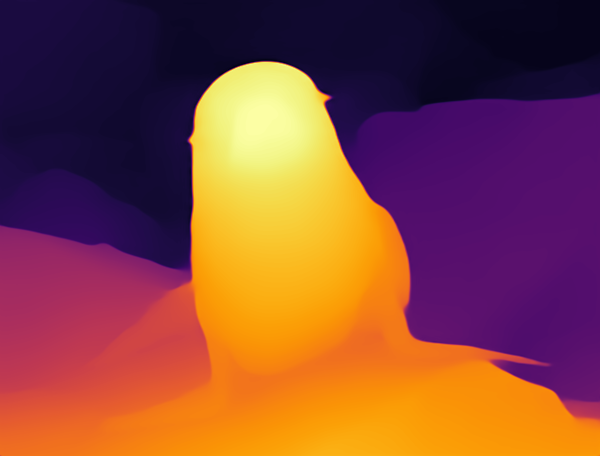

In [2]:
from depth_postprocessor import DepthResults

zoo = dg.connect(hw_location, 'https://cs.degirum.com/degirum/monocular_depth', dgtools.get_token())
model = zoo.load_model(model_float_name, image_backend='pil', input_image_format="RAW", measure_time=True)

DepthResults.color_map = "inferno"
model.custom_postprocessor = DepthResults

results_float = model("furseal.png")
# Display smaller version in notebook
results_float.image_overlay.resize((results_float.image_overlay.size[0] // 4, results_float.image_overlay.size[1] // 4))

### Run inference on video

Successfully opened video stream 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4'


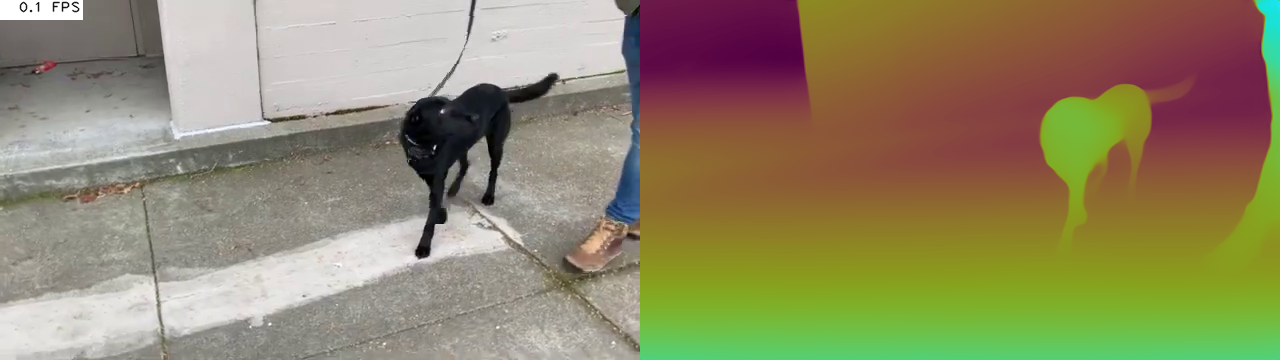

In [3]:
import numpy as np

# Video source: https://www.youtube.com/watch?v=fu1xcQdJRws (Public Domain)
video_source = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"

# Change backend back to opencv for compatibility with dgstreams
model = zoo.load_model(model_float_name, image_backend='opencv', input_image_format="RAW")
DepthResults.color_map = "viridis"
model.custom_postprocessor = DepthResults

with dgtools.Display("AI Camera") as display:
    # AI prediction loop
    # Press 'x' or 'q' to stop
    # Drag zone by left mouse button to move zone
    # Drag zone corners by right mouse button to adjust zone shape
    for inference_result in dgtools.predict_stream(
        model, video_source
    ):
        # Stack video and depth map side by side.
        h, w, c = inference_result.image.shape
        compound_image = np.zeros((h, w * 2, c), dtype=np.uint8)
        compound_image[:h,:w] = inference_result.image
        compound_image[:h, w:] = inference_result.image_overlay

        display.show(compound_image)

## Compare to quantized model

In [ ]:
from PIL import Image, ImageFont, ImageDraw

model_name = 'vits14_depth_anything--518x518_quant_openvino_cpu_1'
zoo = dg.connect(dg.CLOUD, 'https://cs.degirum.com/degirum/monocular_depth', dgtools.get_token())
model = zoo.load_model(model_quant_name, image_backend='pil', input_image_format="RAW", measure_time=True)

DepthResults.color_map = "inferno"
model.custom_postprocessor = DepthResults

results_quant = model("furseal.png")

# Stack float and quant images side by side.
new_size = tuple(map(lambda x: int(x / 2), results_quant.image.size))
compound_image = Image.new('RGB', (results_quant.image.size[0], new_size[1]))
compound_image.paste(results_float.image_overlay.resize(new_size))
compound_image.paste(results_quant.image_overlay.resize(new_size), (new_size[0], 0))
# Label images
draw = ImageDraw.Draw(compound_image)
font = ImageFont.load_default(100)
draw.text((20, 10), "Float", (255, 255, 255), font)
draw.text((new_size[0] + 20, 10), "Quant", (255, 255, 255), font)
compound_image


In [ ]:
# Change backend back to opencv for compatibility with dgstreams
model = zoo.load_model(model_quant_name, image_backend='opencv', input_image_format="RAW")
DepthResults.color_map = "viridis"
model.custom_postprocessor = DepthResults

with dgtools.Display("AI Camera") as display:
    # AI prediction loop
    # Press 'x' or 'q' to stop
    # Drag zone by left mouse button to move zone
    # Drag zone corners by right mouse button to adjust zone shape
    for inference_result in dgtools.predict_stream(
        model, video_source
    ):
        # Stack video and depth map side by side.
        h, w, c = inference_result.image.shape
        compound_image = np.zeros((h, w * 2, c), dtype=np.uint8)
        compound_image[:h,:w] = inference_result.image
        compound_image[:h, w:] = inference_result.image_overlay

        display.show(compound_image)

### Compare inference time of the FP16 and INT8 models

In [ ]:
print(f"Float inference time: {results_float.results[0]['Timing']['CoreInferenceDuration_ms']}")
print(f"Float inference time: {results_quant.results[0]['Timing']['CoreInferenceDuration_ms']}")
print(f"Speedup: {results_float.results[0]['Timing']['CoreInferenceDuration_ms'] / results_quant.results[0]['Timing']['CoreInferenceDuration_ms']}")